<a href="https://colab.research.google.com/github/Oliver-gz/Prophet_Time_Series_Model/blob/main/Prophet_Time_Series_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source:
- 中文出处：https://blog.csdn.net/anshuai_aw1/article/details/83412058
- 英文原文：https://facebook.github.io/prophet/docs/quick_start.html#r-api

# Quick Start
Data：前美式橄榄球四分卫佩顿·曼宁的维基百科主页每日访问量的时间序列数据（2007/12/10 - 2016/01/20）。这个数据集具有多季节周期性、不断变化的增长率和可以拟合特定日期（例如佩顿·曼宁的决赛和超级碗）的情况等 Prophet 适用的性质。

In [6]:
%pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# Import
import pandas as pd
from prophet import Prophet

In [8]:
# Read Data
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Prophet/data/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [9]:
# Fit Model
m = Prophet()
m.fit(df)

14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:34:45 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# 构建待预测日期数据框，periods = 365 代表除历史数据的日期外再往后推 365 天
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [11]:
# 预测数据集
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.208452,7.448620,8.931472
3266,2017-01-16,8.533442,7.822357,9.283223
3267,2017-01-17,8.320853,7.586525,9.088783
3268,2017-01-18,8.153517,7.383286,8.875339
3269,2017-01-19,8.165423,7.386658,8.891850


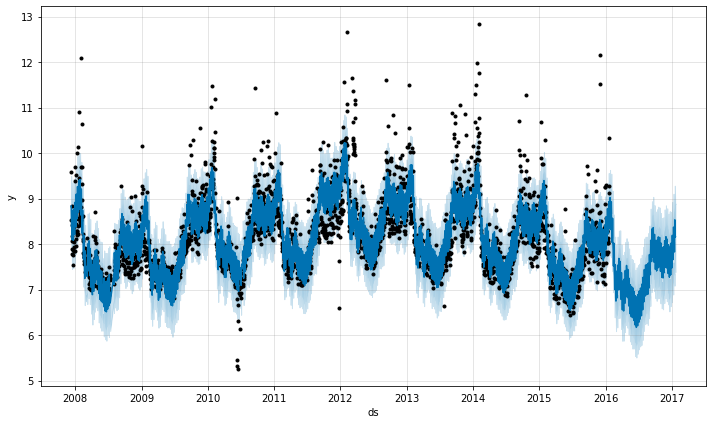

In [12]:
# 展示预测结果
fig1 = m.plot(forecast)

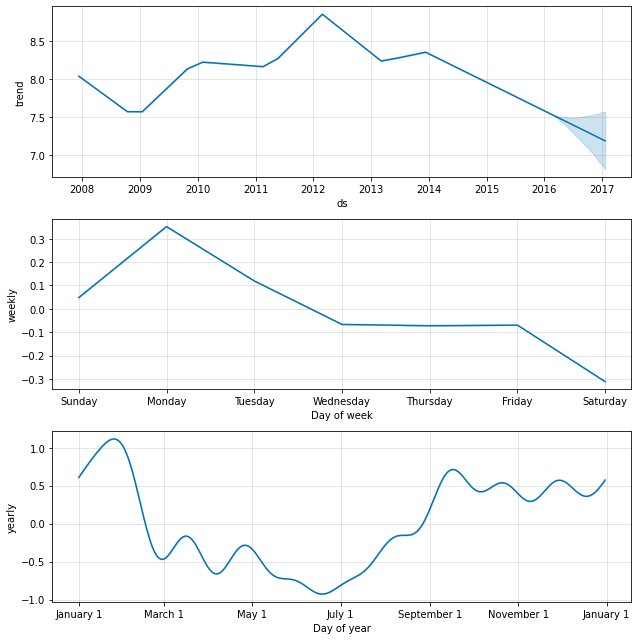

In [13]:
# 预测的成分分析绘图，展示预测中的趋势、周效应和年度效应
fig2 = m.plot_components(forecast)

In [14]:
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


因为是加法模型，有：`forecast['additive_terms'] = forecast['weekly'] + forecast['yearly']`；有：`forecast['yhat']  = forecast['trend'] +  forecast['additive_terms']`。因此：`forecast['yhat']  = forecast['trend'] +forecast['weekly'] + forecast['yearly']`。

'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper'这3列为空.

如果有节假日因素，那么就会有`forecast['yhat']  = forecast['trend'] +forecast['weekly'] + forecast['yearly'] + forecast['holidays']`。对于那些是节假日的天数，`forecast['holidays']`才会有值;不是节假日的天数，`forecast['holidays']`为0。

Weekly中的Monday为0.3的意思就是，在trend的基础上，加0.3；Saturday为-0.3的意思就是，在trend的基础上，减0.3。因此，这条线的高低也在一定程度上反应了“销量的趋势“。

# Saturating Forecasts 具有饱和值的预测

默认情况下， Prophet 使用线性模型进行预测。当预测增长情况时，通常会存在可到达的最大极限值，例如：总市场规模、总人口数等等。这被称做承载能力（carrying capacity），那么预测时就应当在接近该值时趋于饱和（saturate at this point）。

Prophet 可使用 logistic 增长 趋势模型进行预测，同时指定承载能力。

Data：维基百科主页访问量（取对数）

In [15]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Prophet/data/example_wp_log_R.csv')
df.head()

,ds,y
0,2008-01-30,5.976351
1,2008-01-16,6.049733
2,2008-01-17,6.011267
3,2008-01-14,5.953243
4,2008-01-15,5.910797


需要新建一列 cap 来指定承载能力的大小。此处假设取某个特定的值，通常情况下这个值应当通过市场规模的数据或专业知识来决定。

每行都必须指定 cap 的值，但并非需要是恒定值。如果市场规模在不断地增长，那么 cap 也可以是不断增长的序列。

In [16]:
# 新建一列 cap 来指定承载能力
df['cap'] = 8.5

In [17]:
# 新增参数来指定采用 logistic 增长
m = Prophet(growth='logistic')
m.fit(df)

14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:35:00 - cmdstanpy - INFO - Chain [1] done processing


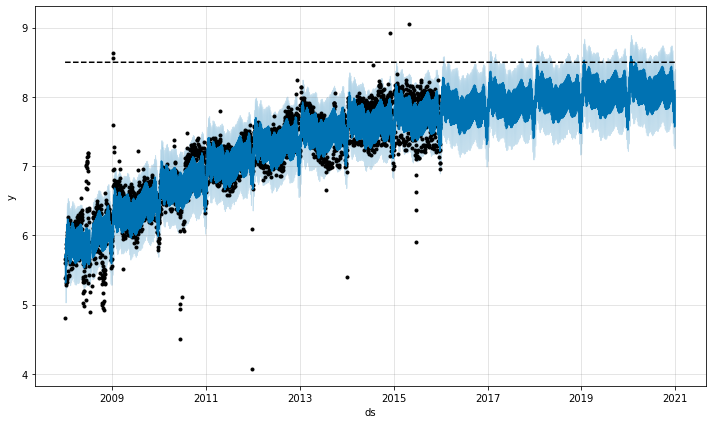

In [18]:
# 预测未来值，同样需要指定未来的承载能力
# 此处设置 cap 和历史值相同，预测3年数据
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m.predict(future)
fig = m.plot(fcst)


Logistic增长函数还可以处理饱和最小值，方法与指定最大值的列的方式相同。
- The logistic function has an implicit minimum of 0, and will saturate at 0 the same way that it saturates at the capacity. It is possible to also specify a different saturating minimum.

但区别在于，对具有saturating minimum的预测问题，同样需要指定saturating maximum，因为此时logistic function没有implicit maximum，必须人为约束。

14:35:13 - cmdstanpy - INFO - Chain [1] start processing
14:35:13 - cmdstanpy - INFO - Chain [1] done processing


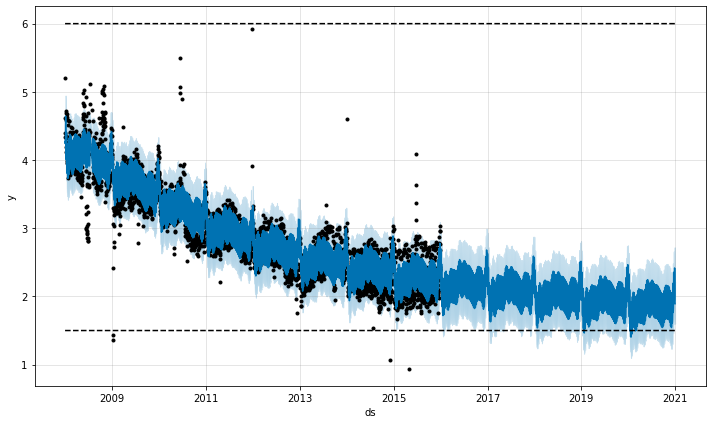

In [19]:
df['y'] = 10 - df['y']
df['cap'] = 6
df['floor'] = 1.5
future['cap'] = 6
future['floor'] = 1.5
m = Prophet(growth='logistic')
m.fit(df)
fcst = m.predict(future)
fig = m.plot(fcst)

# Trend Changepoints 趋势突变点
我们可以发现真实的时间序列数据往往在趋势中存在一些突变点。默认情况下， Prophet 将自动监测到这些点，并对趋势做适当地调整。但这样也会存在一些问题：
- Prophet 不小心忽略了一个趋势速率的变化
- 对历史数据趋势变化存在过拟合现象

此时我们希望针对突变点，对趋势的调整过程做更好地控制。

## Prophet 自动检测突变点

Prophet 首先会识别大量的潜在突变点（变化速率突变），之后对趋势变化的幅度做稀疏先验（等同于 L1 正则化）。

实际上 Prophet 在建模时会存在很多变化速率突变点，但只会尽可能少地使用它们。以第一部分中佩顿·曼宁的数据为例，默认 Prophet 会识别出 25 个潜在的突变点（均匀分布在在前 80% 的时间序列数据中）。下图中的竖线指出这些潜在的突变点所在的位置。

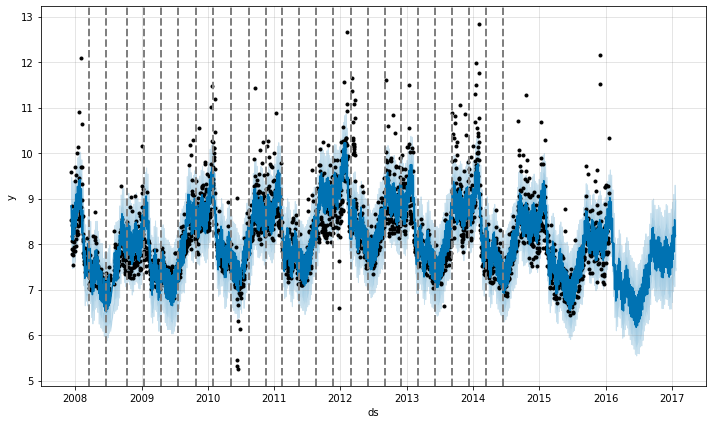

虽然存在很多变化速率可能会突变的点，但由于做了稀疏先验（正则），绝大多数突变点并不会包含在建模过程中。如下图所示，通过观察对每个突变点绘制的速率变化值图，可以发现这一点。

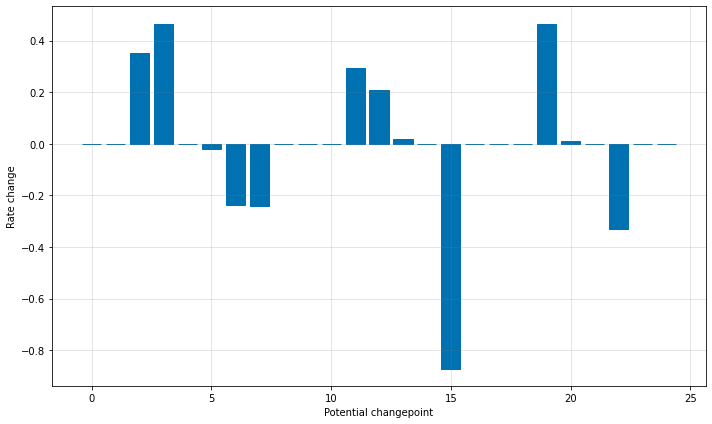

潜在突变点的数量可以通过设置 n_changepoints 参数来指定，但最好还是利用调整正则化来修正。

In [20]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Prophet/data/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

14:35:21 - cmdstanpy - INFO - Chain [1] start processing
14:35:22 - cmdstanpy - INFO - Chain [1] done processing


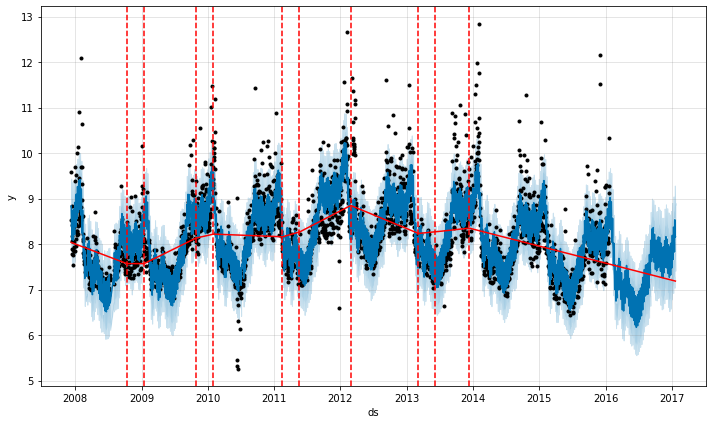

In [21]:
# 获取显著突变点位置
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

默认情况下，只有在时间序列的前80%才会推断出突变点，以便有足够的长度来预测未来的趋势，并避免在时间序列的末尾出现过拟合的波动。

这个80%默认值在很多情况下没问题，但不是所有情况下都可以。可以使用changepoint_range参数进行更改。例如，Python中的 m = Prophet(changepoint_range=0.9)，这意味着将在时间序列的前90%处寻找潜在的突变点。

## 调整趋势的灵活性

如果趋势的变化被过度拟合（即过于灵活）或者拟合不足（即灵活性不够），可以利用输入参数 changepoint_prior_scale 来调整稀疏先验的程度（类似1-L1正则系数）。默认下，这个参数被指定为 0.05 。
- 增加这个值，会导致趋势拟合得更加灵活（拟合更多的历史潜在突变点，容易过拟合）
- 减小这个值，会导致趋势拟合得灵活性降低（拟合更少的历史潜在突变点，容易欠拟合）

14:35:26 - cmdstanpy - INFO - Chain [1] start processing
14:35:28 - cmdstanpy - INFO - Chain [1] done processing


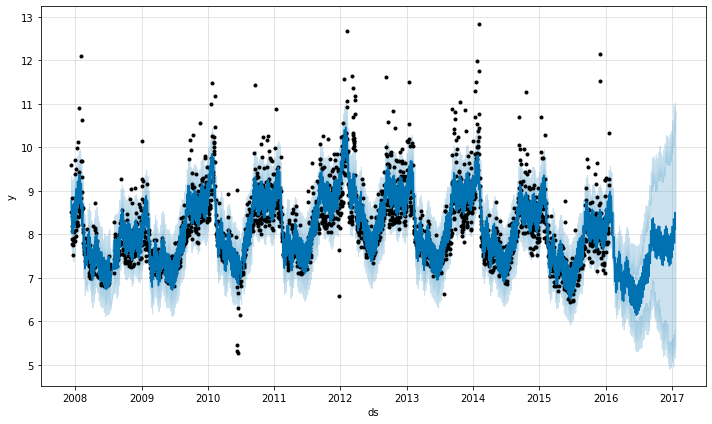

In [22]:
# changepoint_prior_scale=0.5
m = Prophet(changepoint_prior_scale=0.5)
m.fit(df)
future = m.make_future_dataframe(periods=365) 
forecast = m.predict(future)
fig = m.plot(forecast)

14:35:33 - cmdstanpy - INFO - Chain [1] start processing
14:35:33 - cmdstanpy - INFO - Chain [1] done processing


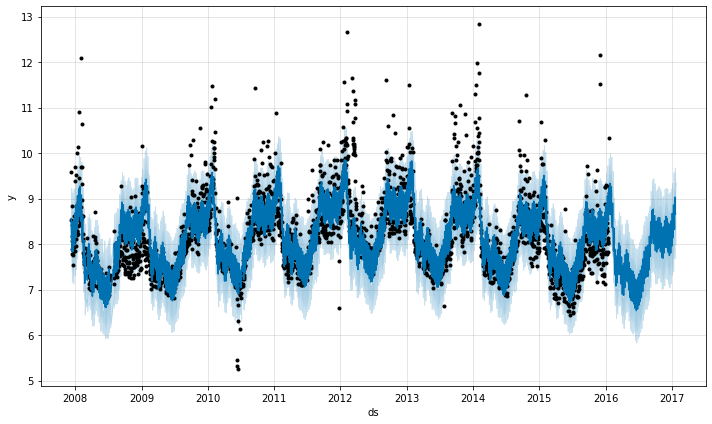

In [23]:
# changepoint_prior_scale=0.001
m = Prophet(changepoint_prior_scale=0.001)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast)

## 人工指定突变点的位置

如果你希望手动指定潜在突变点的位置而不是利用自动的突变点监测，可以使用 changepoints 参数。

14:35:38 - cmdstanpy - INFO - Chain [1] start processing
14:35:38 - cmdstanpy - INFO - Chain [1] done processing


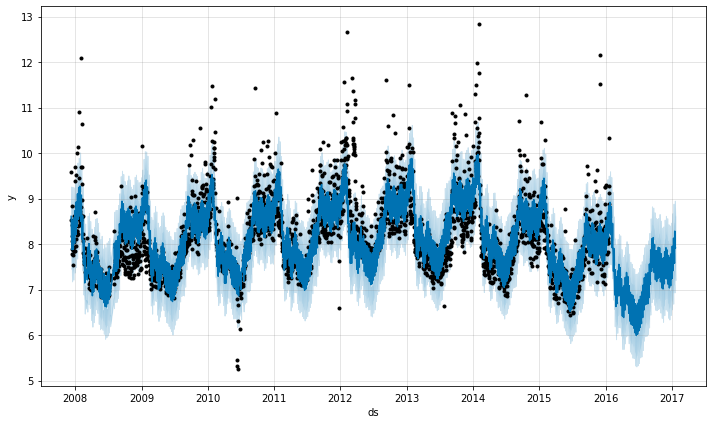

In [24]:
# 指定突变点 2014-01-01
m = Prophet(changepoints=['2014-01-01'])
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast)

# Seasonality, Holiday Effects, And Regressors

## 节假日和特殊事件建模

如果需要专门对节假日或者其它的事件进行建模，你就必须得为此创建一个新的dataframe，其中包含两列：节假日 holiday 和日期戳 ds
- 每行记录一个节假日
- 这个 dataframe 必须包含所有节假日，包括历史数据和待预测时间窗数据
- 如果这些节假日并没有在待预测的时期中被注明，Prophet 只会利用历史数据对它们建模，但预测未来时却不会考虑未包含的节假日

可以在这个数据框基础上再新建两列 lower_window 和 upper_window ，从而将节假日的时间扩展成一个区间 [ lower_window , upper_window ] 。
- 如果想将平安夜也加入到 “圣诞节” 里，就设置 lower_window = -1 , upper_window = 0 
- 如果想将黑色星期五加入到 “感恩节” 里，就设置 lower_window = 0 , upper_window = 1 
- 国庆节7天，lower_window = 0 , upper_window = 6

下面我们创建一个 dataframe，其中包含了所有佩顿·曼宁参加过的决赛日期。

In [25]:
# 此处将超级碗的日期既记录在了决赛的日期数据框中，也记录在了超级碗的日期数据框中
# 这就会造成超级碗日期的效应会在决赛日期的作用下叠加两次
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


In [26]:
# 传入 holidays 参数，预测时加入节假日效应
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Prophet/data/example_wp_log_peyton_manning.csv')
m = Prophet(holidays=holidays)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:42 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
# 看一下假期的最后10行数据
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.22176,1.208297
2191,2014-02-03,1.90146,1.459763
2532,2015-01-11,1.22176,0.000000
2533,2015-01-12,1.90146,0.000000
2901,2016-01-17,1.22176,0.000000
2902,2016-01-18,1.90146,0.000000
2908,2016-01-24,1.22176,0.000000
2909,2016-01-25,1.90146,0.000000
2922,2016-02-07,1.22176,1.208297
2923,2016-02-08,1.90146,1.459763


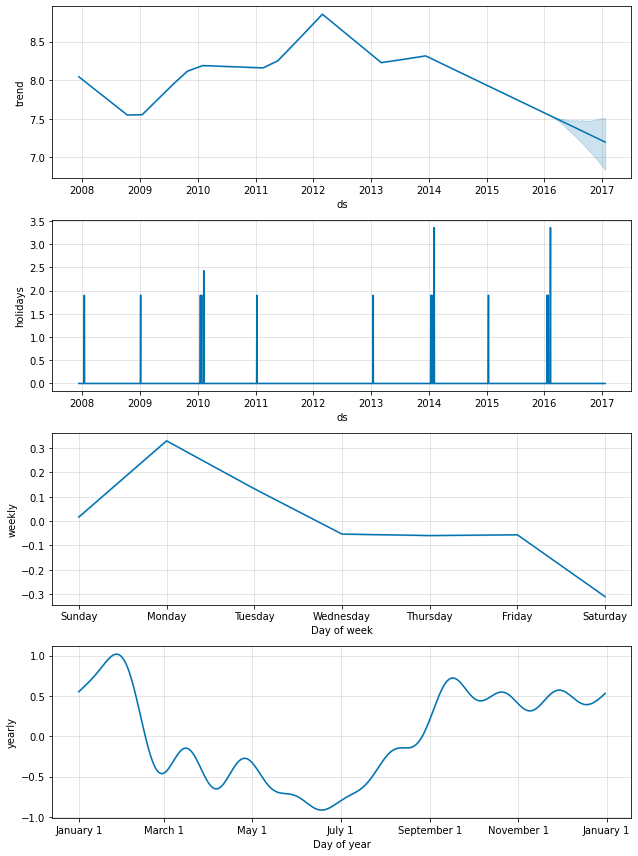

In [28]:
# 成分分析图中可以看到holidays效应
fig = m.plot_components(forecast)

观察节假日效应成分图，在决赛日期附近能看到有一个尖峰，而在超级碗日期时尖峰则更为明显。

另外，Prophet 内置有一些国家的法定节假日，具体可参考官方文档。

## Fourier Order for Seasonalities 季节性的傅里叶级数

季节性是用partial Fourier sum（傅立叶部分和）估计的。有关完整的细节，请参阅论文，以及维基百科，以说明部分傅里叶和如何近似于一个线性周期信号。

部分和中的项数（order）是一个参数，它决定了季节性的变化有多快。为了说明这一点，我们仍似乎用第一部分中佩顿·曼宁的数据。每年季节性的默认傅立叶级数是10。


14:35:48 - cmdstanpy - INFO - Chain [1] start processing
14:35:49 - cmdstanpy - INFO - Chain [1] done processing


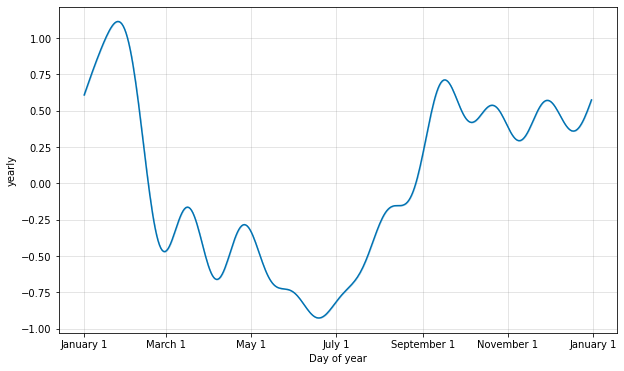

In [29]:
from prophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

默认值10通常是合适的，但是当季节性需要适应更高频率的变化时，它们可以增加，并且通常不那么平滑。在实例化模型时，可以为每个内置季节性指定傅立叶级数，这里增加到20：

14:35:49 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] done processing


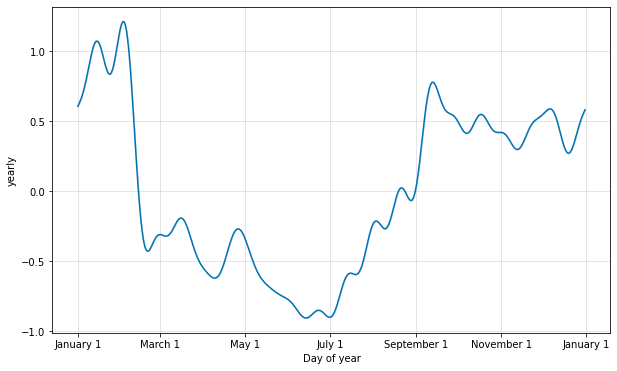

In [30]:
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

可以看到，曲线更加的多变了。增加傅立叶项的数量可以使季节性适应更快的变化周期，但也可能导致过度拟合：N个傅立叶项对应于用于建模周期的2N个变量。

## 自定义季节性因素

如果时间序列超过两个周期，Prophet将默认拟合周和年季节性。对于sub-daily时间序列，也将自动拟合日季节性。在Python中，可以使用add_seasality方法添加其它季节性(如每月、每季、每小时)。

这个函数的输入需要指定季节性类型（name），季节性的周期（period），以及季节性的傅里叶order。默认情况下，周季节性的傅立叶order为3，年季节性为10。add_seasality的另一个可选参数是该季节性组件的先验规模（季节性的正则）。

我们仍使用佩顿·曼宁的数据，但是用每月的季节性替换每周的季节性。

14:35:51 - cmdstanpy - INFO - Chain [1] start processing
14:35:51 - cmdstanpy - INFO - Chain [1] done processing


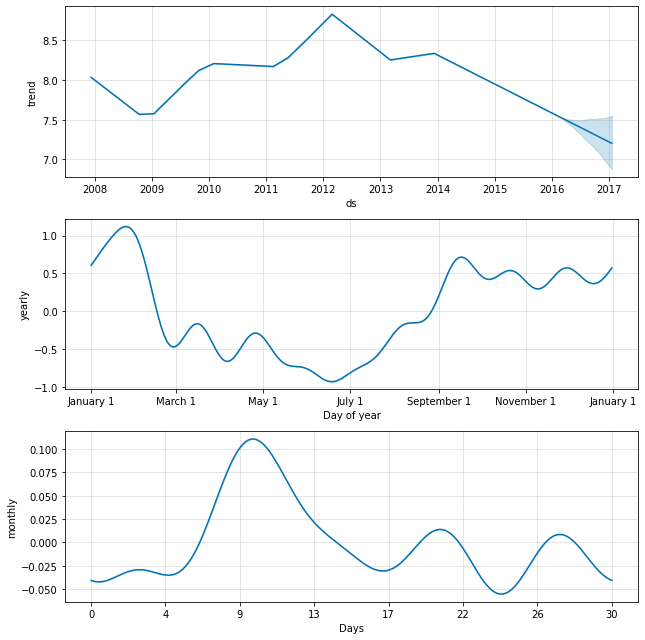

In [31]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

## Seasonalities that depend on other factors

有时季节性依赖于其他因素，如夏季的周季节性可能不同于其他季节，或周末和工作日的日季节性表现不同。These types of seasonalities can be modeled using conditional seasonalities.

考虑Peyton Manning example，默认假设周季节性全年相同，但预期情况是on-season (when there are games every Sunday) 和 off-season是不同的. We can use conditional seasonalities to construct separate on-season and off-season weekly seasonalities.

首先新增两列 boolean 值来标识每个日期是on-season or off-season。

In [32]:
# 标识每个日期是on-season or off-season
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

df['on_season'] = df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)

14:35:57 - cmdstanpy - INFO - Chain [1] start processing
14:35:58 - cmdstanpy - INFO - Chain [1] done processing


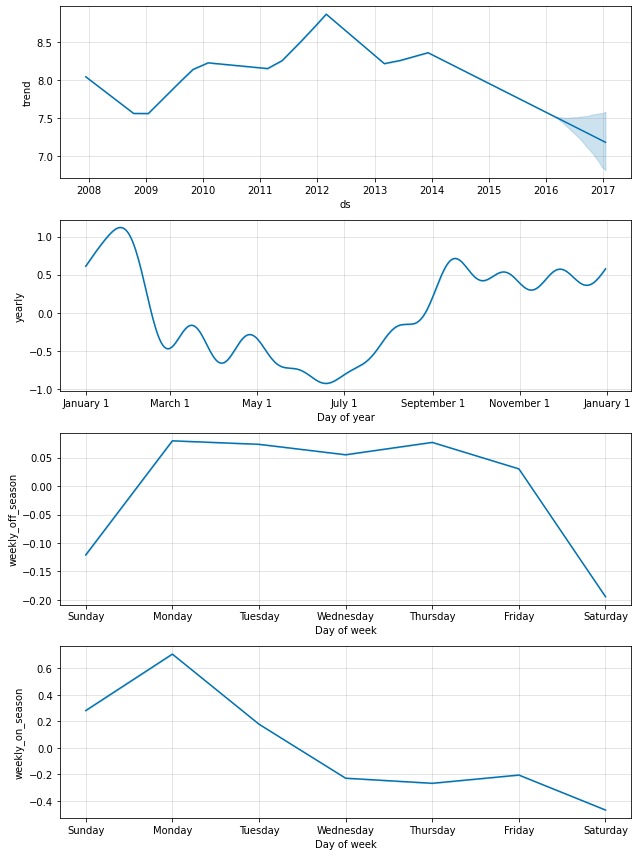

In [33]:
# 舍弃默认周季节性，用自定义的两个不同的周季节性代替
# the seasonality will only be applied to dates where the condition_name column is True
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

可以看到 on-season（Sunday），there are large increases on Sunday and Monday that are completely absent during the off-season.

## 对节假日和季节性设定先验规模

如果发现节假日效应过拟合了，可以通过设置参数 holidays_prior_scale 来调整它们的先验规模来使之平滑，默认值为10。

In [34]:
# 减少 holidays_prior_scale 降低节假日效应
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

14:36:04 - cmdstanpy - INFO - Chain [1] start processing
14:36:05 - cmdstanpy - INFO - Chain [1] done processing


,ds,playoff,superbowl
2190,2014-02-02,1.207765,0.963348
2191,2014-02-03,1.855854,0.990907
2532,2015-01-11,1.207765,0.000000
2533,2015-01-12,1.855854,0.000000
2901,2016-01-17,1.207765,0.000000
2902,2016-01-18,1.855854,0.000000
2908,2016-01-24,1.207765,0.000000
2909,2016-01-25,1.855854,0.000000
2922,2016-02-07,1.207765,0.963348
2923,2016-02-08,1.855854,0.990907


类似的，还有一个 seasonality_prior_scale 参数可以用来调整模型对于季节性的拟合程度。 

可以通过在节假日的dataframe中包含一个列prior_scale来单独设置先验规模。独立的季节性的先验规模可以作为add_seasonality的参数传递。例如，可以使用以下方法设置周季节性的先验规模:

In [35]:
m = Prophet()
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

## Additional regressors 附加回归量

可以使用add_regressor方法将附加的回归量添加到模型的线性部分。包含回归量的列需要同时出现在拟合数据格式（fit）和预测数据格式(predict)中。例如，我们可以在NFL赛季的周日添加附加的效果。在成分图上，这种效果会出现在“extra_regre_”图中:

14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:10 - cmdstanpy - INFO - Chain [1] done processing


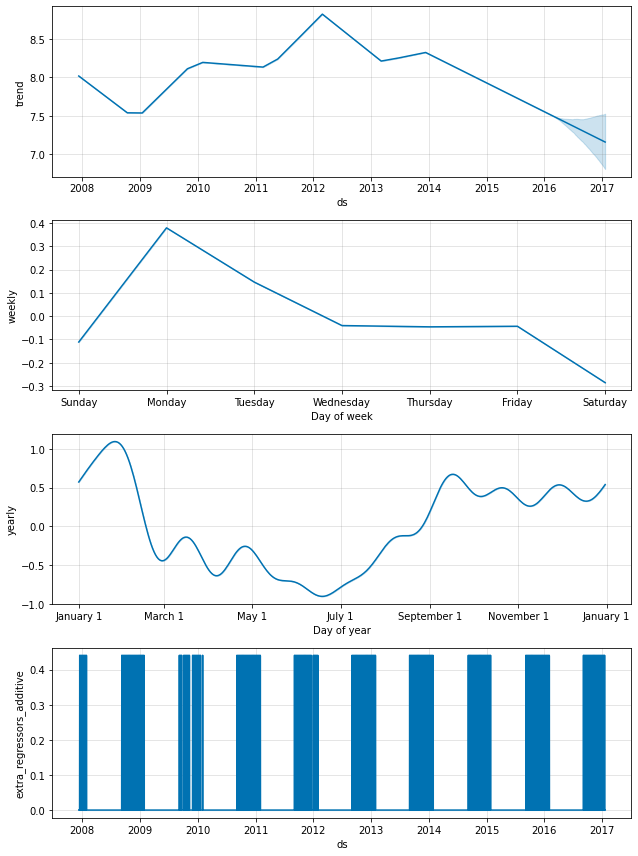

In [36]:
# 判断是否是NFL赛季的周日
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)
 
m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)
 
future['nfl_sunday'] = future['ds'].apply(nfl_sunday)
 
forecast = m.predict(future)
fig = m.plot_components(forecast)

NFL周日也可以使用之前描述的“节假日”的接口，通过创建一个过去和未来NFL周日的list。add_regressor函数为定义附加的线性回归函数提供了一个更通用的接口，特别是它不要求回归函数是二进制指示器。

add_regressor函数具有可选的参数，用于指定先验规模(默认情况下使用节假日先验规模)，和指定是否标准化回归量。help(Prophet.add_regressor)可以查看相关参数。

附加的回归量必须要知道历史和未来的日期。因此，它要么是已知未来值(比如nfl_sunday)，要么是其他地方已经单独预测出的结果。如果回归量在整个历史中都是不变的，则Prophet会引发一个错误，因为没有任何东西可以fit它。

附加的回归量被放在模型的线性分量中，所以依赖于附加的回归量时间序列作为底层模型的加法或乘法因子。

# Multiplicative Seasonality 乘法季节性

默认情况下，Prophet使用加法季节性，即季节性的影响是加到趋势中得到了最后的预测值（yhat）。而航空旅客数量的时间序列是一个加法季节性不起作用的例子

14:36:16 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing


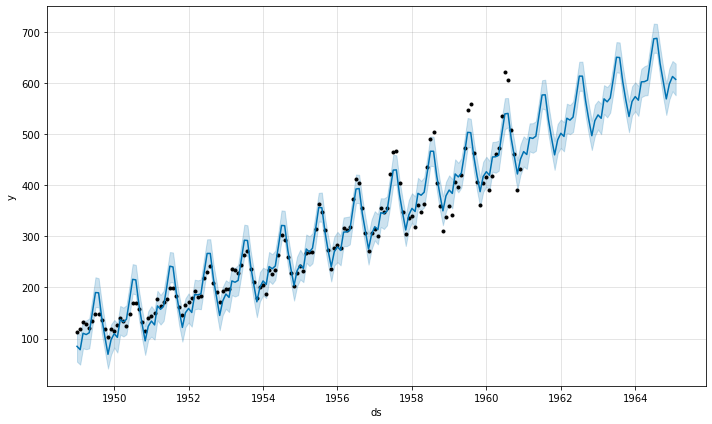

In [37]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Prophet/data/example_air_passengers.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

这个时间序列有一个明显的年度周期，但这个季节性并不是恒定的，而是而是随着趋势在增长，这就是乘法季节性（multiplicative seasonality）。但预测时Prophet默认假设它是一个恒定的加性因子，使得预测的季节性在时间序列开始时太大，在结束时又太小。

Prophet可以通过设置seasonality_mode='multiplicative'来使用乘法季节性。

14:51:05 - cmdstanpy - INFO - Chain [1] start processing
14:51:05 - cmdstanpy - INFO - Chain [1] done processing


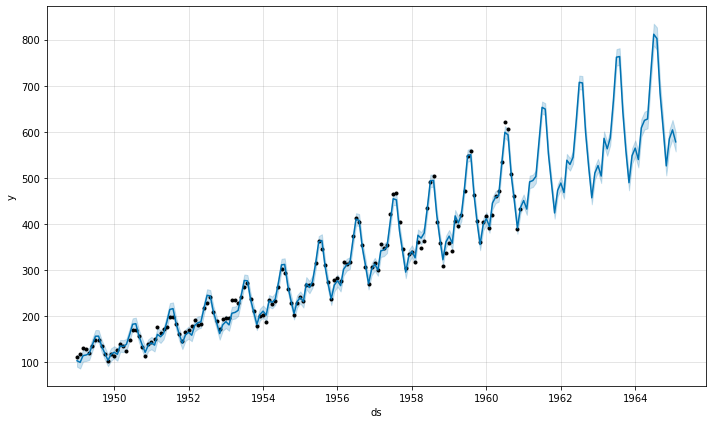

In [39]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)

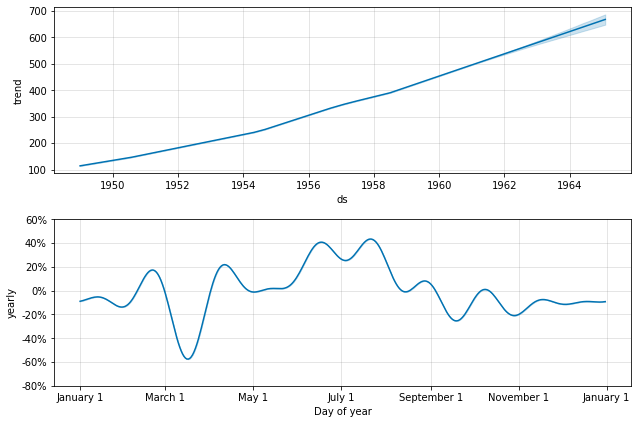

In [40]:
# 乘法季节性的成分图
fig = m.plot_components(forecast)

因为是乘法模型，有：
- `forecast['multiplicative_terms'] = forecast['yearly']`；因此：`forecast['yhat']  = forecast['trend'] * (1+forecast['multiplicative_terms'])`。
- 使用seasonality_mode='multiplicative'，节假日也将被建模为乘法效果。
- 'additive_terms', 'additive_terms_lower', 'additive_terms_upper'这3列为0

默认情况下，任何添加的季节性或额外的回归量都可以使用seasality_mode设置为加法或者是乘法。但假如在添加季节性或回归量时，指定mode='addiative'或mode='multiplicative'作为参数来覆盖之前的设定。

例如，下面将内置的季节性设置为乘法，但添加了一个加法季度季节性来覆盖原本的乘法。这个时候是时间序列的混合模型（实际情况中几乎不太可能）：`forecast['yhat'] = forecast['trend']  * (1+forecast['multiplicative_terms']) + forecast['additive_terms']`。

In [43]:
m = Prophet(seasonality_mode='multiplicative')
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
m.add_regressor('regressor', mode='additive')

# Uncertainty Intervals 预测区间

默认情况下， Prophet 的返回结果中会包括预测值 yhat 的预测区间。当然，预测区间的估计需建立在一些重要的假设前提下。

在预测时，不确定性主要来源于三个部分：趋势中的不确定性（uncertainty in the trend）、季节效应估计中的不确定性（uncertainty in the seasonality estimates）和观测值的噪声影响（additional observation noise）。

## 趋势的不确定性

预测中，不确定性最大的来源就在于未来趋势改变的不确定性。在之前的时间序列实例中，我们可以发现历史数据具有明显的趋势性。Prophet 能够监测并去拟合它，但是我们期望得到的趋势改变究竟会如何走向呢？或许这是无解的，因此我们尽可能地做出最合理的推断，假定“未来将会和历史具有相似的趋势”。尤其重要的是，我们假定未来趋势的平均变动频率和幅度和我们观测到的历史值是一样的，从而预测趋势的变化并通过计算，最终得到预测区间。

这种衡量不确定性的方法具有以下性质：变化速率灵活性更大时（通过增大参数 changepoint_prior_scale 的值），预测的不确定性也会随之增大。原因在于如果将历史数据中更多的变化速率加入了模型，也就代表我们认为未来也会变化得更多，就会使得预测区间成为反映过拟合的标志。

预测区间的宽度（默认80%）可以通过设置 interval_width 参数来控制。

In [45]:
m = Prophet(interval_width=0.95).fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

15:16:18 - cmdstanpy - INFO - Chain [1] start processing
15:16:18 - cmdstanpy - INFO - Chain [1] done processing


由于预测区间估计时假设未来将会和过去保持一样的变化频率和幅度，而这个假设可能并不正确，所以预测区间的估计不可能完全准确。

## 季节的不确定性

默认情况下， Prophet 只会返回趋势中的不确定性和观测值噪声的影响。你必须使用贝叶斯取样的方法来得到季节效应的不确定性，可通过设置 mcmc.samples 参数（默认值为 0 ）来实现。下面使用佩顿·曼宁的数据为例。

In [46]:
# df = pd.read_csv('drive/MyDrive/Colab Notebooks/Prophet/data/example_wp_log_peyton_manning.csv')
# m = Prophet(mcmc_samples=300)
# forecast = m.fit(df, show_progress=False).predict(future)

15:27:58 - cmdstanpy - INFO - CmdStan installation /usr/local/lib/python3.7/dist-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
15:27:58 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:27:58 - cmdstanpy - INFO - CmdStan start processing
15:27:58 - cmdstanpy - INFO - Chain [1] start processing
15:27:58 - cmdstanpy - INFO - Chain [2] start processing
15:32:47 - cmdstanpy - INFO - Chain [2] done processing
15:32:47 - cmdstanpy - INFO - Chain [3] start processing
15:33:02 - cmdstanpy - INFO - Chain [1] done processing
15:33:02 - cmdstanpy - INFO - Chain [4] start processing
15:37:39 - cmdstanpy - INFO - Chain [3] done processing
15:37:49 - cmdstanpy - INFO - Chain [4] done processing
15:37:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_gl

上述代码将最大后验估计（ MAP ）取代为马尔科夫蒙特卡洛取样 （ MCMC ），并且计算时间大大延长（取决于数据量），大概从 10 秒延长到 10 分钟。如果做了全采样，就能通过绘图看到季节效应的不确定性了。

In [ ]:
# fig = m.plot_components(forecast)

可以使用m.predictive_samples(future)方法在Python中访问原始的后验预测样本。

在PyStan有一些针对Windows的上游问题，这使得MCMC采样非常缓慢。在Windows中，MCMC采样的最佳选择是在Linux VM中使用R或Python。

# Outliers 异常值

异常值主要通过两种方式影响 Prophet 预测结果。下面我们使用之前使用过的 维基百科主页对数访问量的数据来建模预测，只不过使用存在时间间隔并不完整的数据。



16:08:20 - cmdstanpy - INFO - Chain [1] start processing
16:08:23 - cmdstanpy - INFO - Chain [1] done processing


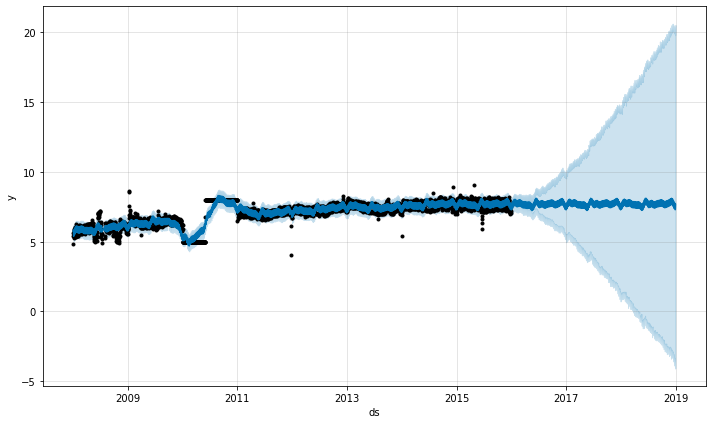

In [47]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Prophet/data//example_wp_log_R_outliers1.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)

如上输出图所示，趋势预测看似合理，预测区间的估计却过于广泛。 Prophet 虽能够处理历史数据中的异常值，但仅仅是将它们与趋势的变化拟合在一起，认为未来也会有类似的趋势变化。

处理异常值最好的方法是移除它们，而 Prophet 是能够处理缺失数据的。如果在历史数据中某行的值为空（ NA ），但是在待预测日期数据框 future 中仍保留这个日期，那么 Prophet 依旧可以给出该行的预测值。

16:09:32 - cmdstanpy - INFO - Chain [1] start processing
16:09:34 - cmdstanpy - INFO - Chain [1] done processing


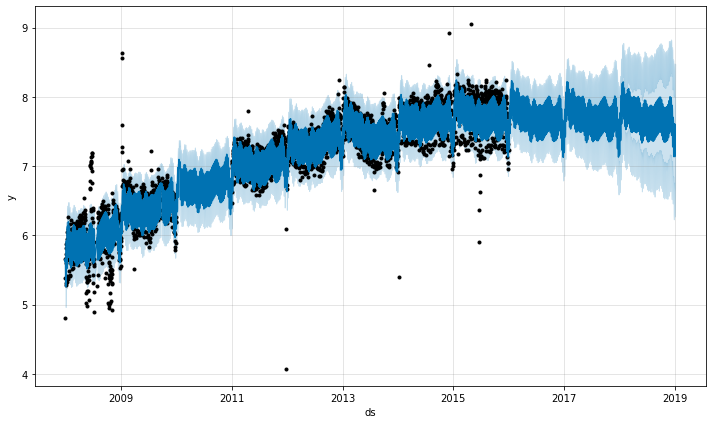

In [48]:
df.loc[(df['ds'] > '2010-01-01') & (df['ds'] < '2011-01-01'), 'y'] = None
model = Prophet().fit(df)
fig = model.plot(model.predict(future))

上述这个实例虽然影响了不确定性的估计，却没有影响到主要的预测值 yhat 。但是，现实往往并非如此，接下来，在上述数据集基础上加入新的异常值后再建模预测。

16:11:48 - cmdstanpy - INFO - Chain [1] start processing
16:11:49 - cmdstanpy - INFO - Chain [1] done processing


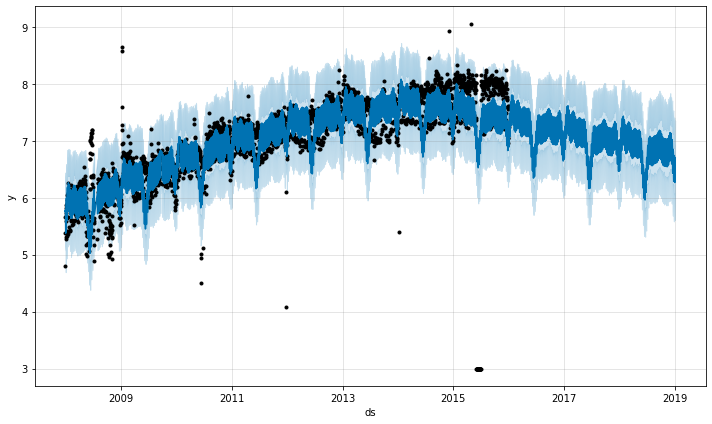

In [49]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Prophet/data/example_wp_log_R_outliers2.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)

这里 2015年 6 月存在一些异常值破坏了季节效应的估计，因此未来的预测也会永久地受到这个影响。最好的解决方法就是移除这些异常值。

16:12:51 - cmdstanpy - INFO - Chain [1] start processing
16:12:53 - cmdstanpy - INFO - Chain [1] done processing


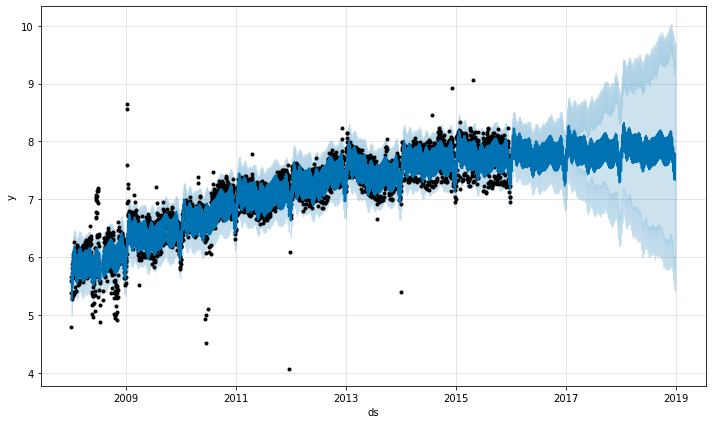

In [50]:
df.loc[(df['ds'] > '2015-06-01') & (df['ds'] < '2015-06-30'), 'y'] = None
m = Prophet().fit(df)
fig = m.plot(m.predict(future))

# Non-Daily Data 非每日数据

## Sub-daily data 子日数据

Prophet可以通过在ds列中传递一个带有时间戳的dataframe来对时间序列进行子日（Sub-daily）观测。时间戳的格式应该是YYYY-MM-DD - HH:MM:SS。当使用子日数据时，日季节性将自动匹配。在这里，我们用5分钟的分辨率数据集(约塞米蒂的每日温度)对Prophet进行数据匹配。

16:15:40 - cmdstanpy - INFO - Chain [1] start processing
16:15:45 - cmdstanpy - INFO - Chain [1] done processing


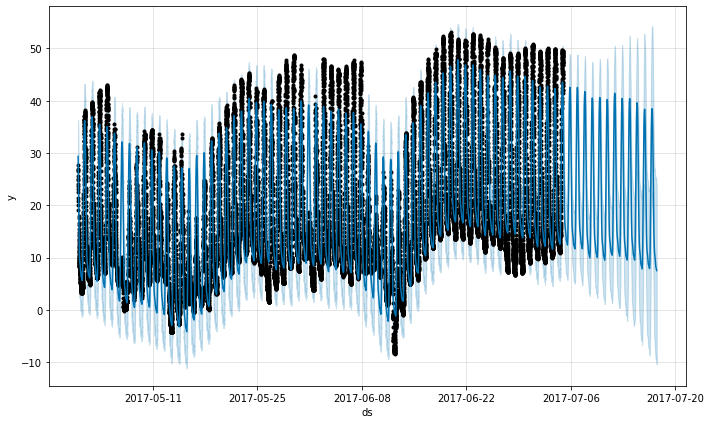

In [51]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Prophet/data/example_yosemite_temps.csv')
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

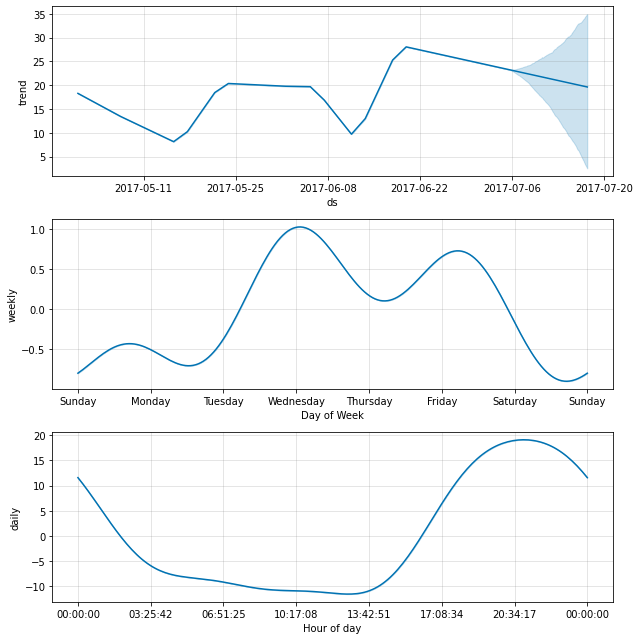

In [52]:
# 成分图中的日季节性
fig = m.plot_components(fcst)

## Data with regular gaps 有规律间隔的数据

假设上面的数据集只有每天早上6点之前的观测值。

16:17:17 - cmdstanpy - INFO - Chain [1] start processing
16:17:23 - cmdstanpy - INFO - Chain [1] done processing


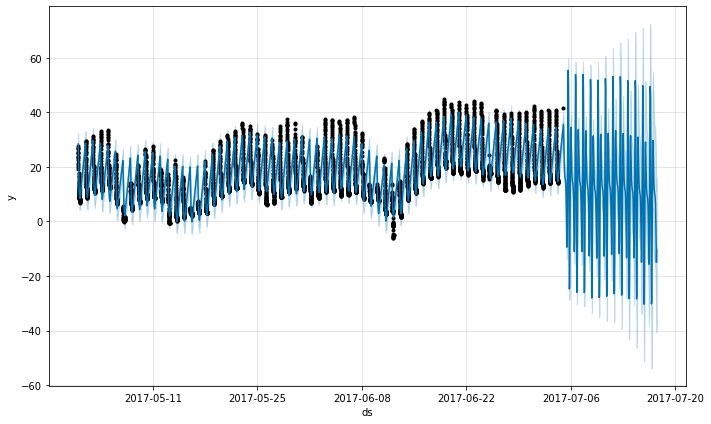

In [53]:
df2 = df.copy()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2[df2['ds'].dt.hour < 6]
m = Prophet().fit(df2)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

这个预测看起来很差，未来的波动比历史上看到的要大得多。这里的问题是，我们将每天的循环安排在一个时间序列中，这个时间序列中只有一天的一部分数据(12am到6am)。因此，每天的季节性在一天剩下的时间里是不受约束的，估计也不准确。解决方案是只对有历史数据的时间窗进行预测。这里，这意味着限制未来dataframe的时间（从12am到6am）。

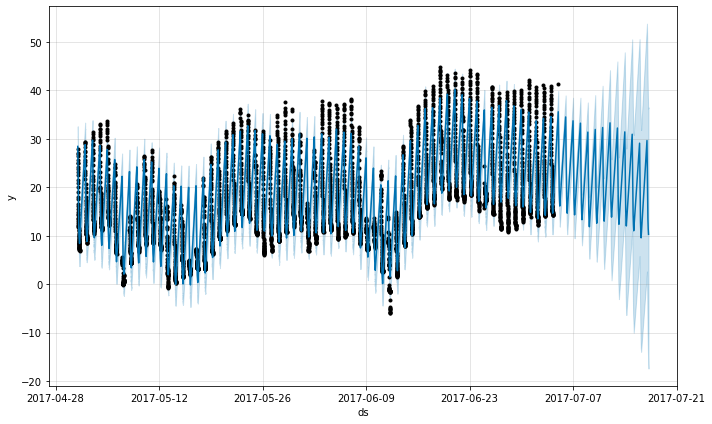

In [54]:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour < 6]
fcst = m.predict(future2)
fig = m.plot(fcst)

同样的原理也适用于数据中有规则间隔的其他数据集。例如，如果历史只包含工作日，那么应该只对工作日进行预测，因为周末的季节性无法很好地估计。

## Monthly data 月度数据

可以使用Prophet来匹配每月的数据。然而，Prophet 的基本模型是连续时间的，这意味着如果将模型与每月的数据相匹配，然后要求每天的预测，我们会得到奇怪的结果。

下面使用美国零售业销售量数据来预测未来 10 年的情况。

16:21:22 - cmdstanpy - INFO - Chain [1] start processing
16:21:22 - cmdstanpy - INFO - Chain [1] done processing


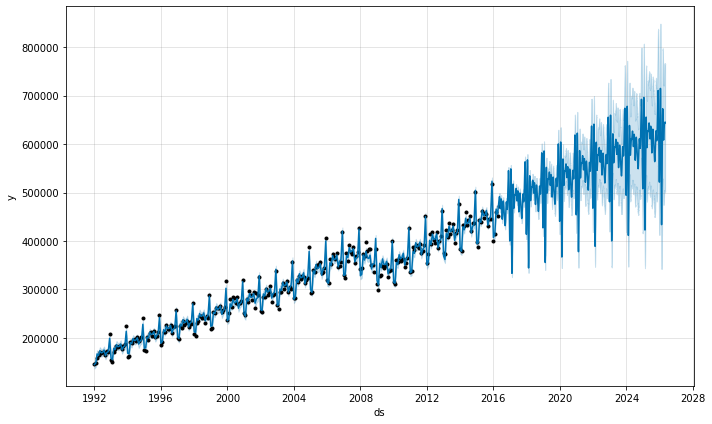

In [55]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Prophet/data/example_retail_sales.csv')
m = Prophet(seasonality_mode='multiplicative').fit(df)
future = m.make_future_dataframe(periods=3652)
fcst = m.predict(future)
fig = m.plot(fcst)

预测结果看起来非常杂乱，这里的问题和上面具有规律间隔的数据相同。当我们你和年季节性时，我们只有每月第一天的数据，其他日期的季节性效应难以识别且是过拟合的。通过MCMC采样能够看到这种季节不确定性。

16:22:17 - cmdstanpy - INFO - CmdStan installation /usr/local/lib/python3.7/dist-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
16:22:17 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
16:22:17 - cmdstanpy - INFO - CmdStan start processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [2] start processing
16:22:41 - cmdstanpy - INFO - Chain [1] done processing
16:22:41 - cmdstanpy - INFO - Chain [3] start processing
16:22:44 - cmdstanpy - INFO - Chain [2] done processing
16:22:44 - cmdstanpy - INFO - Chain [4] start processing
16:23:05 - cmdstanpy - INFO - Chain [3] done processing
16:23:07 - cmdstanpy - INFO - Chain [4] done processing
16:23:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm

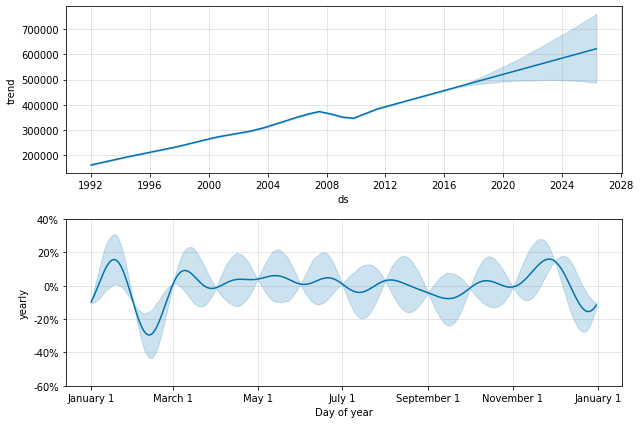

In [56]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(df, show_progress=False)
fcst = m.predict(future)
fig = m.plot_components(fcst)

季节性在月初具有low uncertainty，但在月中则有very high posterior variance。

当你使用 Prophet 拟合月度数据时，可以通过在 make_future_dataframe 中传入频率参数只做月度的预测。 

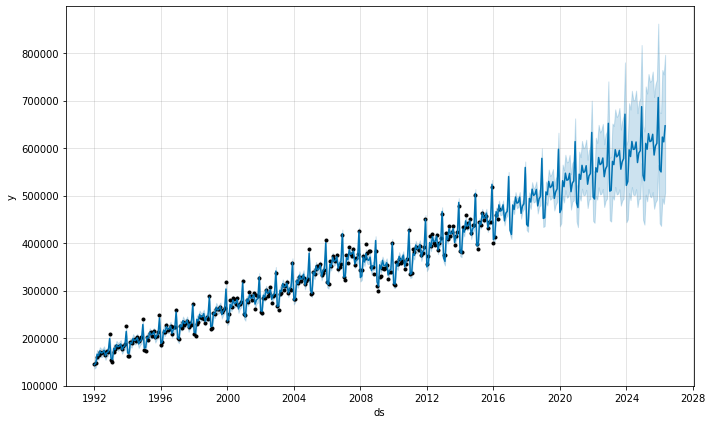

In [57]:
future = m.make_future_dataframe(periods=120, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

# Diagnostics 模型诊断

## Cross validation 交叉验证

Prophet包含时间序列交叉验证功能，以测量使用历史数据的预测误差。这是通过在历史记录中选择截止点来完成的，对于每一个都只使用该截止点之前的数据来拟合模型。然后，我们可以将预测值与实际值进行比较。

这张图展示了对Peyton Manning数据集的模拟历史预测，该模型适用于5年的初始历史，并在1年的时间范围内进行了预测。

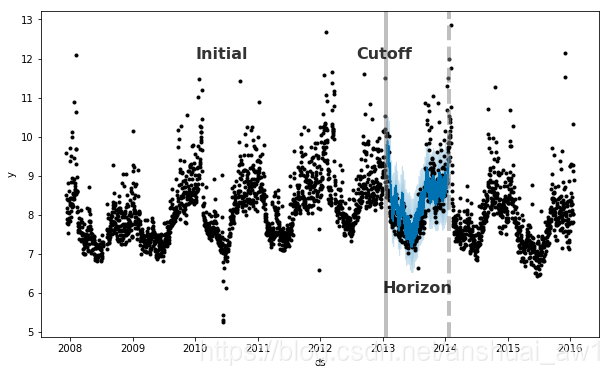

论文原文 https://peerj.com/preprints/3190.pdf 有详细说明。更多关于时间序列预测的cross validation也可参考：
- https://otexts.com/fpp3/tscv.html
- https://lonepatient.top/2018/06/10/time-series-nested-cross-validation

交叉验证过程可以使用cross_validation函数自动完成一系列历史cutoffs。具体的需要指定3个参数：默认情况下，初始训练期设置为horizon的3倍，每半个horizon就有一个截断(即period=0.5*horizon)。
- initial：初始训练数据时间窗大小
- period：预测时间窗平移量
- horizon：预测时间窗大小

举例说明：对Peyton Manning数据集作交叉验证，initial = 730天，period = 180天，horizon = 365天，注：Peyton Manning数据一共大约8年多（2007-12-10 - 2016-01-20）
- 第一个模型：用前730天训练（2007-12-19 - 2010-02-15），第一个 cutoff 在 2010-02-15，对接下来的365天进行预测（2010-02-15 - 2011-02-15）
- 第二个模型：从第一个 cutoff 向后平移180天得到第二个 cutoff（2010-08-15），用前 730 + 180 天的数据进行训练（2007-12-19 - 2010-08-15），对接下来的365天进行预测（2010-08-15 - 2011-08-15）
- 以此类推，最后一个 cutoff 在 2015-01-20，在2010-02-15到2015-01-20共有1800天，对应着10个 cutoff，因此共11个 cutoff，对应有11个模型

cross_validation的输出是一个dataframe，在每个模拟预测日期和每个截断日期都有真实值y和样本预测值yhat。特别地，对在 cutoff 和 cutoff + horizon 之间的每一个观测点都进行了预测。然后，这个dataframe可以用来度量yhat和y之间的error。


In [92]:
from prophet.diagnostics import cross_validation
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Prophet/data/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

19:51:19 - cmdstanpy - INFO - Chain [1] start processing
19:51:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/11 [00:00<?, ?it/s]

19:51:20 - cmdstanpy - INFO - Chain [1] start processing
19:51:20 - cmdstanpy - INFO - Chain [1] done processing
19:51:23 - cmdstanpy - INFO - Chain [1] start processing
19:51:24 - cmdstanpy - INFO - Chain [1] done processing
19:51:26 - cmdstanpy - INFO - Chain [1] start processing
19:51:27 - cmdstanpy - INFO - Chain [1] done processing
19:51:29 - cmdstanpy - INFO - Chain [1] start processing
19:51:30 - cmdstanpy - INFO - Chain [1] done processing
19:51:32 - cmdstanpy - INFO - Chain [1] start processing
19:51:33 - cmdstanpy - INFO - Chain [1] done processing
19:51:35 - cmdstanpy - INFO - Chain [1] start processing
19:51:36 - cmdstanpy - INFO - Chain [1] done processing
19:51:38 - cmdstanpy - INFO - Chain [1] start processing
19:51:39 - cmdstanpy - INFO - Chain [1] done processing
19:51:41 - cmdstanpy - INFO - Chain [1] start processing
19:51:42 - cmdstanpy - INFO - Chain [1] done processing
19:51:44 - cmdstanpy - INFO - Chain [1] start processing
19:51:45 - cmdstanpy - INFO - Chain [1]

In [93]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.954355,8.442682,9.436894,8.242493,2010-02-15
1,2010-02-17,8.720730,8.190196,9.226251,8.008033,2010-02-15
2,2010-02-18,8.604357,8.083364,9.073137,8.045268,2010-02-15
3,2010-02-19,8.526162,8.032875,9.001634,7.928766,2010-02-15
4,2010-02-20,8.267999,7.801545,8.754775,7.745003,2010-02-15
...,...,...,...,...,...,...
3983,2016-01-16,8.582400,7.875250,9.341671,7.817223,2015-01-20
3984,2016-01-17,8.977079,8.329753,9.765543,9.273878,2015-01-20
3985,2016-01-18,9.283216,8.563720,10.082357,10.333775,2015-01-20
3986,2016-01-19,9.066367,8.376888,9.799850,9.125871,2015-01-20


In [94]:
# 查看前两个period的交界处
df_cv.iloc[350:370]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
350,2011-02-09,10.472156,9.886392,11.060785,8.283241,2010-02-15
351,2011-02-10,10.360511,9.775400,10.949856,8.273337,2010-02-15
352,2011-02-11,10.279587,9.723962,10.818019,8.159089,2010-02-15
353,2011-02-12,10.011321,9.469952,10.569021,7.913521,2010-02-15
354,2011-02-13,10.325258,9.821379,10.924244,7.840706,2010-02-15
355,2011-02-14,10.527968,9.989626,11.078979,8.024862,2010-02-15
356,2011-02-15,10.228677,9.645143,10.787872,7.971431,2010-02-15
357,2010-08-15,7.762147,7.229620,8.303473,8.307706,2010-08-14
358,2010-08-16,8.018671,7.479224,8.513937,8.280711,2010-08-14
359,2010-08-17,7.840814,7.320302,8.384617,8.744488,2010-08-14


也可以自定义 cutoff 的位置（a list of dates）。

In [95]:
# three cutoffs six months apart
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

  0%|          | 0/3 [00:00<?, ?it/s]

19:51:54 - cmdstanpy - INFO - Chain [1] start processing
19:51:55 - cmdstanpy - INFO - Chain [1] done processing
19:51:58 - cmdstanpy - INFO - Chain [1] start processing
19:51:58 - cmdstanpy - INFO - Chain [1] done processing
19:52:01 - cmdstanpy - INFO - Chain [1] start processing
19:52:01 - cmdstanpy - INFO - Chain [1] done processing


利用 performance_metrics 可以计算一些衡量预测性能的统计指标：
- 均方误差(mean squared error, MSE)
- 均方根误差(root mean squared error, RMSE)
- 平均绝对误差(mean absolute error, MAE)
- 平均绝对误差(mean absolute percent error, MAPE)
- yhat_lower和yhat_upper预测区间的覆盖率（yhat 在预测区间内的概率）

这些都是在df_cv中通过horizon (ds - cutoff)排序后预测的滚动窗口中计算出来的。默认情况下，每个窗口都会包含10%的预测，但是可以通过rolling_window参数来更改。若rolling_window=1，则用全部数据计算指标。具体逻辑参考GitHub：https://github.com/facebook/prophet/issues/839

In [113]:
df_cv[(df_cv['y']>df_cv['yhat_lower']) & (df_cv['y']<df_cv['yhat_upper'])]# and (df_cv['y']<df_cv['yhat_upper']) else 0]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
7,2010-02-24,8.356587,7.792094,8.882509,8.310415,2010-02-15
8,2010-02-25,8.277318,7.797768,8.811897,7.828038,2010-02-15
9,2010-02-26,8.239045,7.711407,8.709207,7.873598,2010-02-15
10,2010-02-27,8.022760,7.533282,8.511693,7.757051,2010-02-15
15,2010-03-04,8.239655,7.720930,8.727243,8.068090,2010-02-15
...,...,...,...,...,...,...
3978,2016-01-11,9.096151,8.401086,9.809332,8.470730,2015-01-20
3980,2016-01-13,8.720859,7.988076,9.455979,8.067149,2015-01-20
3984,2016-01-17,8.977079,8.329753,9.765543,9.273878,2015-01-20
3986,2016-01-19,9.066367,8.376888,9.799850,9.125871,2015-01-20


In [115]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.493203,0.702284,0.503793,0.058351,0.049677,0.058664,0.676565
1,38 days,0.499038,0.706426,0.508760,0.058925,0.049585,0.059298,0.675423
2,39 days,0.521223,0.721958,0.514844,0.059523,0.049600,0.060022,0.672682
3,40 days,0.528452,0.726947,0.517657,0.059823,0.049427,0.060392,0.673824
4,41 days,0.535851,0.732018,0.518542,0.059889,0.049585,0.060521,0.681361
...,...,...,...,...,...,...,...,...
324,361 days,1.116749,1.056763,0.856777,0.102652,0.087143,0.101821,0.497031
325,362 days,1.132091,1.063998,0.863429,0.103256,0.087584,0.102378,0.497716
326,363 days,1.153241,1.073891,0.870894,0.104014,0.087894,0.103012,0.492919
327,364 days,1.169585,1.081474,0.878455,0.104936,0.089352,0.103750,0.488808


交叉验证性能指标可以用plot_cross_validation_metric可视化，这里显示的是MAPE。点表示df_cv中每个预测的绝对误差百分比。蓝线显示的是MAPE，为滚动窗口内的均值。我们可以看到，对于一个月后的预测，误差在5%左右，而对于一年之后的预测，误差会增加到11%左右。

/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning: casting 

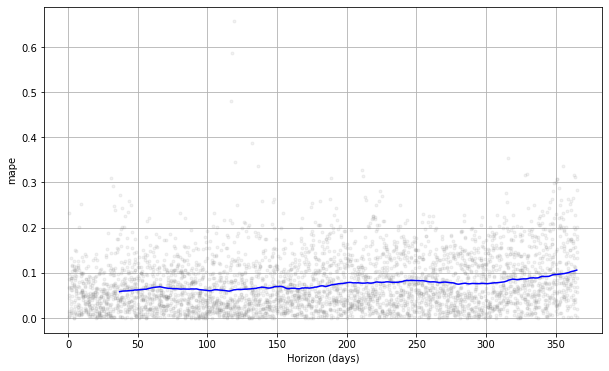

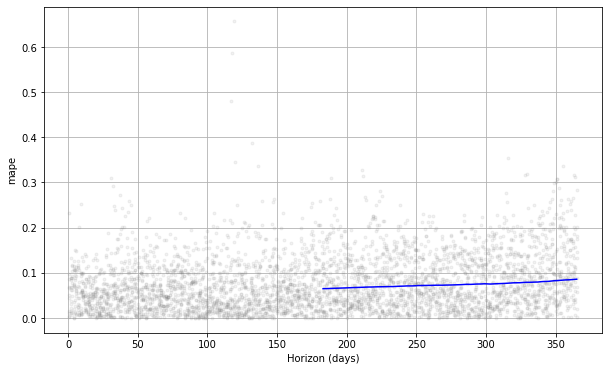

In [118]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.1)
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.5)

图中滚动窗口的大小也可以通过可选参数rolling_window更改，默认值为0.1。增大该值的话将导致图中平均曲线更平滑。

初始周期应该足够长，以捕获模型的所有特性，特别是季节性和额外的回归变量:对年的季节性至少保证一年，对周的季节性至少保证一周，等等。

## Hyperparameter tuning 调参

交叉验证也可用于模型调参，如 changepoint_prior_scale 和 seasonality_prior_scale 等超参数。下面是一个调参示例，参数空间为一个4x4网格，支持多个cutoffs并行计算，评估指标选择horizon=30天对应的RMSE。

In [88]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1) # Calculate metrics using all data without rolling average
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

19:45:53 - cmdstanpy - INFO - Chain [1] start processing
19:45:54 - cmdstanpy - INFO - Chain [1] done processing
19:45:55 - cmdstanpy - INFO - Chain [1] start processing
19:45:55 - cmdstanpy - INFO - Chain [1] start processing
19:45:55 - cmdstanpy - INFO - Chain [1] done processing
19:45:55 - cmdstanpy - INFO - Chain [1] done processing
19:45:58 - cmdstanpy - INFO - Chain [1] start processing
19:45:58 - cmdstanpy - INFO - Chain [1] done processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:01 - cmdstanpy - INFO - Chain [1] done processing
19:46:01 - cmdstanpy - INFO - Chain [1] done processing
19:46:03 - cmdstanpy - INFO - Chain [1] start processing
19:46:03 - cmdstanpy - INFO - Chain [1] done processing
19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1]

In [89]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.001,0.01,0.757572
1,0.001,0.10,0.755242
2,0.001,1.00,0.753498
3,0.001,10.00,0.759586
4,0.010,0.01,0.544645
5,0.010,0.10,0.541304
6,0.010,1.00,0.528225
7,0.010,10.00,0.520748
8,0.100,0.01,0.522026
9,0.100,0.10,0.519338


In [90]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


Prophet模型中有多个参数，某些建议调节，但某些并不建议调节。具体的调参建议可见：https://facebook.github.io/prophet/docs/diagnostics.html#parallelizing-cross-validation

建议调节：

changepoint_prior_scale
- 多数情况下是影响最大的参数，决定趋势拟合灵活度，本质上是L1 Lasso penalty。如果太小，则存在欠拟合风险，本应包含在趋势项中的variance回进入noise term。如果太大，则存在过拟合风险
- 默认值0.05，建议调节区间为 [0.001, 0.5]

seasonality_prior_scale
- 控制季节性拟合灵活度。类似的，过小会导致欠拟合，过大会导致过拟合。本质上是L2 Ridge penalty
- 默认值10.0，即基本无regularization，这是因为季节性过拟合的情况很少见，因为建模过程使用的截断傅立叶低通滤波，本身具备一层正则的效果
- 合理的区间为 [0.01, 10]，当取0.01时，季节性效应会非常小

holidays_prior_scale
- 控制节假日你和灵活度
- 默认值10.0，即基本无regularization，因为通常我们有很多关于节假日的历史数据，所以能比较准确地估计节假日效应
- 合理的区间也为 [0.01, 10]

seasonality_mode
- 两种取值 ['additive', 'multiplicative']
- 默认为'additive'加法模型，但也有很多情况下需要使用乘法模型。可以先直接观察时间序列图，看季节性波动是否逐渐增大。若无法得出结论则可以通过模型调整

# 总体工作流

1. 去除数据中的异常点（outliers）。可以直接赋值为None，因为Prophet的设计中可以通过插值处理缺失值，但是对异常值比较敏感。
2. 选择趋势模型（growth）。默认使用分段线性的趋势（linear），一般只有在存在saturating point的情况下，会选择分段log的增长趋势（logistic）。
3. 设置趋势转折点（changepoint）。根据业务经验，如果我们确定时间序列的趋势会在某些位置发现转变，可以直接人工设置。比如新产品上线的当天。
4. 设置季节性类型（seasonality）。模型默认拟合年/周/天的季节性，取决于具体的数据粒度。根据数据的特征，可以人为进行设置月/小时的季节性，或者设置将年/周等季节性关闭。
5. 设置节假日特征（holiday）。如果我们的数据存在节假日的突增或者突降，我们可以设置holiday参数来进行调节，包括时间名称和时间窗。
6. 拟合模型，并简单作图观察，如果预测结果的误差很大，考虑选取的模型是否准确，然后可以根据经验继续调节上述模型参数。
7. 调参（hyperparameter tuning）。选择合适的评估指标，根据模型是否过拟合以及对什么成分过拟合，调节参数以调整regularization，如seasonality_prior_scale、holidays_prior_scale、change_point_prior_scale。
8. 如果在尝试多次后，某些日期的预测依然存在很大的误差，说明历史数据可能仍存在未被剔除的异常值。
9. 如果对历史数据进行预测时发现，从一个截点到下一个截点误差急剧增加，这说明在两个截点期间数据的产生过程存在较大变化，此时两个截点之间应该增加一个”changepoint”，来对这期间的不同阶段分别建模。
